In [1]:
import os
os.chdir("../")
print(os.getcwd())

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

C:\Users\ismae\Desktop\PhD_codes\TurbulentEncoderTransformerDecoder


In [12]:
nx, ny = 64, 64
T = 800
num_steps = 1000
batch_size = 16
lr = 1e-5
device = "cuda" if torch.cuda.is_available() else "cpu"

In [13]:
Phi_inference = np.load(kolmo_flow_inference)[traj:traj+1, 1:, :]
print(Phi_inference.shape)

(1, 801, 8192)


In [14]:
# kolmo_flow_closure = "Data/Kolmogorov/processed_data/npyfiles/kolmo_closure.npy"
# kolmo_flow_filtered = "Data/Kolmogorov/processed_data/npyfiles/kolmo_filtered.npy"
# kolmo_flow_inference = "kolmo_f_inference_results.npy"

kolmo_flow_closure = "D:/data/Kolmogorov/kolmo_100s_8traj.npy"
kolmo_flow_filtered = "D:/data/Kolmogorov/kolmo_filtered_100s_8ens.npy"
kolmo_flow_inference = "D:/data/Kolmogorov/kolmo_filtered_200s_inference.npy"

Phi_f = np.load(kolmo_flow_filtered)[traj:traj+1]
U_f =  Phi_f[:, :, :(nx*ny)].reshape(1, T, nx, ny)
V_f =  Phi_f[:, :, (nx*ny):].reshape(1, T, nx, ny)
Phi_f = np.concatenate([U_f, V_f], axis = 0)

Phi_closure = np.load(kolmo_flow_closure)[traj:traj+1]
U_closure =  Phi_closure[:, :, :(nx*ny)].reshape(1, T, nx, ny)
V_closure =  Phi_closure[:, :, (nx*ny):].reshape(1, T, nx, ny)
Phi_closure = np.concatenate([U_closure, V_closure], axis = 0)

Phi_inference = np.load(kolmo_flow_inference)[traj:traj+1, 1:, :]
U_inference =  Phi_inference[:, 1:, :(nx*ny)].reshape(1, T, nx, ny)
V_inference =  Phi_inference[:, 1:, (nx*ny):].reshape(1, T, nx, ny)
Phi_inference = np.concatenate([U_inference, V_inference], axis = 0)

print(Phi_f.shape, Phi_closure.shape, Phi_inference.shape)

(2, 800, 64, 64) (2, 800, 64, 64) (2, 800, 64, 64)


In [15]:
class TimeSplitDataset(Dataset):
    def __init__(self, filtered, closure):
        # filtered, closure shape: (2, T, nx, ny)
        self.filtered = torch.tensor(filtered, dtype=torch.float32)
        self.closure = torch.tensor(closure, dtype=torch.float32)
        self.T = self.filtered.shape[1]

    def __len__(self):
        return self.T

    def __getitem__(self, idx):
        # return data at time idx: (channels, nx, ny)
        return self.filtered[:, idx, :, :], self.closure[:, idx, :, :]

T = Phi_f.shape[1]
    
split_idx = int(T * 0.8)  # 80% train, 20% test

filtered_train = Phi_f[:, :split_idx, :, :]   # shape (2, train_T, nx, ny)
filtered_test = Phi_f[:, split_idx:, :, :]    # shape (2, test_T, nx, ny)

closure_train = Phi_closure[:, :split_idx, :, :]
closure_test = Phi_closure[:, split_idx:, :, :]

train_dataset = TimeSplitDataset(filtered_train, closure_train)
test_dataset = TimeSplitDataset(filtered_test, closure_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [16]:
# Define noise schedule (linear)
beta_start = 0.0001
beta_end = 0.02
betas = torch.linspace(beta_start, beta_end, num_steps).to(device)
alphas = 1 - betas
alphas_cumprod = torch.cumprod(alphas, dim=0)

In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.conv(x)

class DeepUNet(nn.Module):
    def __init__(self, input_channels=4, output_channels=2):
        super().__init__()

        # Downsampling path
        self.dconv_down1 = DoubleConv(input_channels, 64)   # 64x64 -> 64x64
        self.dconv_down2 = DoubleConv(64, 128)              # 32x32
        self.dconv_down3 = DoubleConv(128, 256)             # 16x16
        self.dconv_down4 = DoubleConv(256, 512)             # 8x8
        self.dconv_down5 = DoubleConv(512, 1024)            # 4x4 bottleneck

        self.maxpool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        # Upsampling path
        self.dconv_up4 = DoubleConv(1024 + 512, 512)        # 8x8
        self.dconv_up3 = DoubleConv(512 + 256, 256)         # 16x16
        self.dconv_up2 = DoubleConv(256 + 128, 128)         # 32x32
        self.dconv_up1 = DoubleConv(128 + 64, 64)           # 64x64

        self.conv_last = nn.Conv2d(64, output_channels, kernel_size=1)

    def forward(self, x):
        # Encoder
        conv1 = self.dconv_down1(x)   # 64x64
        x = self.maxpool(conv1)       # 32x32

        conv2 = self.dconv_down2(x)   # 32x32
        x = self.maxpool(conv2)       # 16x16

        conv3 = self.dconv_down3(x)   # 16x16
        x = self.maxpool(conv3)       # 8x8

        conv4 = self.dconv_down4(x)   # 8x8
        x = self.maxpool(conv4)       # 4x4 bottleneck

        x = self.dconv_down5(x)       # 4x4

        # Decoder
        x = self.upsample(x)          # 8x8
        x = torch.cat([x, conv4], dim=1)
        x = self.dconv_up4(x)

        x = self.upsample(x)          # 16x16
        x = torch.cat([x, conv3], dim=1)
        x = self.dconv_up3(x)

        x = self.upsample(x)          # 32x32
        x = torch.cat([x, conv2], dim=1)
        x = self.dconv_up2(x)

        x = self.upsample(x)          # 64x64
        x = torch.cat([x, conv1], dim=1)
        x = self.dconv_up1(x)

        return self.conv_last(x)


In [18]:
model = DeepUNet().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
mse = nn.MSELoss()

In [19]:
def q_sample(x0, t, noise=None):
    """
    Sample noisy image x_t given x_0 and timestep t using:
    x_t = sqrt(alphas_cumprod[t]) * x_0 + sqrt(1 - alphas_cumprod[t]) * noise
    """
    if noise is None:
        noise = torch.randn_like(x0)
    sqrt_alpha_cumprod = alphas_cumprod[t].sqrt().view(-1,1,1)
    sqrt_one_minus_alpha_cumprod = (1 - alphas_cumprod[t]).sqrt().view(-1,1,1)
    return sqrt_alpha_cumprod * x0 + sqrt_one_minus_alpha_cumprod * noise

In [20]:
epochs = 1000
for epoch in range(epochs):
    model.train()
    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}")
    total_loss = 0
    for filtered, closure in loop:

        filtered = filtered.to(device)  # [B,1,H,W]
        closure = closure.to(device)    # [B,1,H,W]

        batch_size_curr = filtered.shape[0]
        t = torch.randint(0, num_steps, (batch_size_curr,), device=device)  # random timestep per sample

        noise = torch.randn_like(closure).to(device)
        # Produce noisy image at step t for each sample
        x_t = torch.zeros_like(closure)
        for i in range(batch_size_curr):
            x_t[i] = q_sample(closure[i], t[i], noise=noise[i])

        x_in = torch.cat([x_t, filtered], dim = 1)
        noise_pred = model(x_in)

        loss = mse(noise_pred, noise)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        loop.set_postfix(loss=total_loss/(loop.n+1))

print("Training finished.")

Epoch 1000: 100%|█████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 30.92it/s, loss=0.0133]

Training finished.


Epoch 272: 100%|████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 22.59it/s, loss=0.0161]


Epoch 340: 100%|████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 16.20it/s, loss=0.0128]


Epoch 408: 100%|████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 16.71it/s, loss=0.0136]


Epoch 476: 100%|████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 16.89it/s, loss=0.0112]


Epoch 544: 100%|███████████████████████████████████████████████████████| 100/100 [00:04<00:00, 22.33it/s, loss=0.00828]


Epoch 612: 100%|████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 22.12it/s, loss=0.0083]


Epoch 680: 100%|███████████████████████████████████████████████████████| 100/100 [00:04<00:00, 23.36it/s, loss=0.00855]


Epoch 748: 100%|███████████████████████████████████████████████████████| 100/100 [00:04<00:00, 22.59it/s, loss=0.00758]


Epoch 816: 100%|███████████████████████████████████████████████████████| 100/100 [00:05<00:00, 17.79it/s, loss=0.00867]


Epoch 884: 100%|███████████████████████████████████████████████████████| 100/100 [00:05<00:00, 16.82it/s, loss=0.00799]


Epoch 952: 100%|████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 17.00it/s, loss=0.0065]


Epoch 1020: 100%|██████████████████████████████████████████████████████| 100/100 [00:04<00:00, 20.94it/s, loss=0.00514]


Epoch 1088: 100%|██████████████████████████████████████████████████████| 100/100 [00:05<00:00, 17.41it/s, loss=0.00611]


Epoch 1156: 100%|██████████████████████████████████████████████████████| 100/100 [00:04<00:00, 22.30it/s, loss=0.00572]


Epoch 1224: 100%|██████████████████████████████████████████████████████| 100/100 [00:06<00:00, 15.09it/s, loss=0.00658]


Epoch 1292: 100%|██████████████████████████████████████████████████████| 100/100 [00:06<00:00, 14.63it/s, loss=0.00459]


Epoch 1360: 100%|██████████████████████████████████████████████████████| 100/100 [00:06<00:00, 14.55it/s, loss=0.00447]


Epoch 1428: 100%|██████████████████████████████████████████████████████| 100/100 [00:06<00:00, 16.30it/s, loss=0.00437]


Epoch 1496: 100%|██████████████████████████████████████████████████████| 100/100 [00:06<00:00, 14.59it/s, loss=0.00563]


Epoch 1564: 100%|██████████████████████████████████████████████████████| 100/100 [00:06<00:00, 14.86it/s, loss=0.00393]


Epoch 1632: 100%|██████████████████████████████████████████████████████| 100/100 [00:06<00:00, 16.18it/s, loss=0.00423]


Epoch 1700: 100%|██████████████████████████████████████████████████████| 100/100 [00:04<00:00, 23.76it/s, loss=0.00371]


Epoch 1768: 100%|██████████████████████████████████████████████████████| 100/100 [00:05<00:00, 16.80it/s, loss=0.00363]


Epoch 1836: 100%|██████████████████████████████████████████████████████| 100/100 [00:05<00:00, 16.74it/s, loss=0.00474]


Epoch 1904: 100%|██████████████████████████████████████████████████████| 100/100 [00:05<00:00, 17.00it/s, loss=0.00442]


Epoch 1972: 100%|██████████████████████████████████████████████████████| 100/100 [00:05<00:00, 17.03it/s, loss=0.00371]


Epoch 2000: 100%|██████████████████████████████████████████████████████| 100/100 [00:06<00:00, 16.65it/s, loss=0.00367]

Training finished.


In [21]:
@torch.no_grad()
def sample(model, filtered_img, steps=num_steps):
    """
    Generate a high-res image from filtered image by reverse diffusion.
    """
    model.eval()
    filtered_img = filtered_img.unsqueeze(0).to(device)  # [1,2,H,W]

    x_t = torch.randn_like(filtered_img)  # start from pure noise

    for t in reversed(range(steps)):
        t_batch = torch.full((1,), t, device=device, dtype=torch.long)

        beta_t = betas[t]
        alpha_t = alphas[t]
        alpha_cumprod_t = alphas_cumprod[t]
        x_in = torch.cat([x_t, filtered_img], dim = 1)

        noise_pred = model(x_in)

        coef1 = 1 / alpha_t.sqrt()
        coef2 = beta_t / (1 - alpha_cumprod_t).sqrt()

        x_prev = coef1 * (x_t - coef2 * noise_pred)

        if t > 0:
            noise = torch.randn_like(x_t)
            sigma_t = beta_t.sqrt()
            x_t = x_prev + sigma_t * noise
        else:
            x_t = x_prev

    return x_t.squeeze()

In [22]:
idx = 0
filtered_example = torch.tensor(filtered_test[:, idx, ...], dtype=torch.float32)
result = torch.tensor(closure_test[:, idx, ...], dtype=torch.float32)
reconstructed = sample(model, filtered_example).cpu().numpy()

In [23]:
result = result.numpy()

In [24]:
error = np.sum(np.abs(result- reconstructed)) / np.sum(np.abs(result)) * 100
print(error)

5.169014632701874


(2, 64, 64)


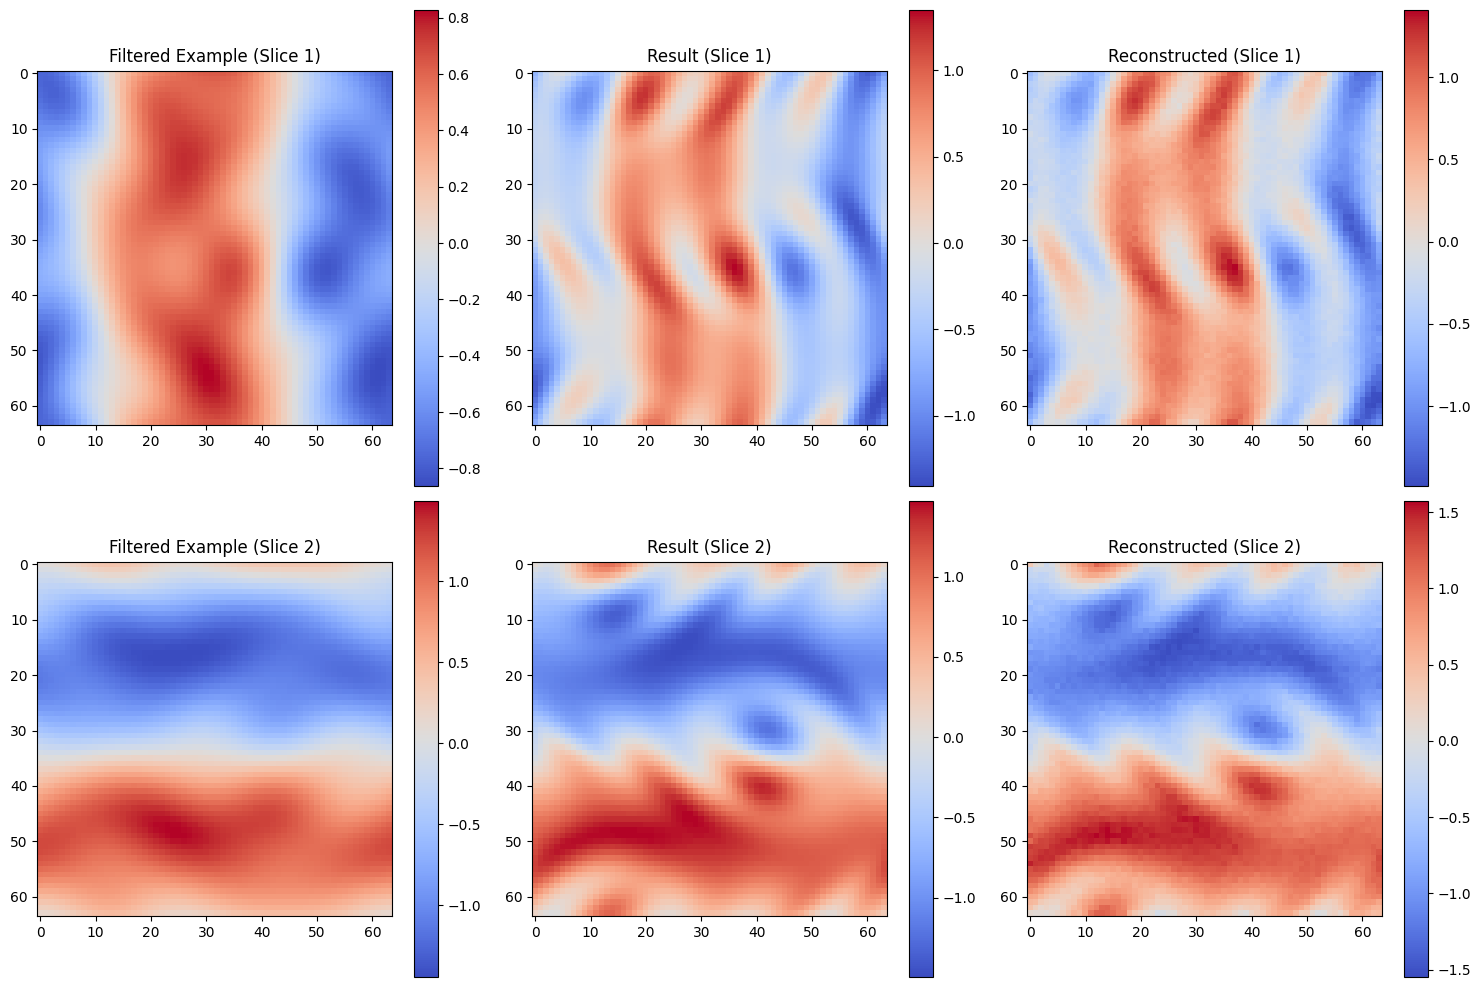

In [25]:
import matplotlib.pyplot as plt
print(reconstructed.shape)
plt.figure(figsize=(15, 10))

# First row: first slice
plt.subplot(2, 3, 1)
plt.imshow(filtered_example[0,...], cmap='coolwarm')
plt.colorbar()
plt.title('Filtered Example (Slice 1)')

plt.subplot(2, 3, 2)
plt.imshow(result[0,...], cmap='coolwarm')
plt.colorbar()
plt.title('Result (Slice 1)')

plt.subplot(2, 3, 3)
plt.imshow(reconstructed[0,...], cmap='coolwarm')
plt.colorbar()
plt.title('Reconstructed (Slice 1)')

# Second row: second slice
plt.subplot(2, 3, 4)
plt.imshow(filtered_example[1,...], cmap='coolwarm')  # Different slice
plt.colorbar()
plt.title('Filtered Example (Slice 2)')

plt.subplot(2, 3, 5)
plt.imshow(result[1,...], cmap='coolwarm')  # Different slice
plt.colorbar()
plt.title('Result (Slice 2)')

plt.subplot(2, 3, 6)
plt.imshow(reconstructed[1,...], cmap='coolwarm')  # Different slice
plt.colorbar()
plt.title('Reconstructed (Slice 2)')

plt.tight_layout()
plt.show()


In [26]:
from tqdm import tqdm
import random

ensemble_size = 15
D =  20
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = model.to(device)
model.eval()

B, L, H, W = closure_test.shape
samples = random.sample(range(L + 1), D)
print(samples)

closure_test_sample = closure_test[:, samples, :, :]
filtered_test_sample = filtered_test[:, samples, :, :]

Phi_hat_ens = torch.zeros((ensemble_size, B, D, H, W), dtype=torch.float32, device=device)
print(Phi_hat_ens.shape)
for n in range(ensemble_size):
    Phi_hat = torch.zeros((B, D, H, W), dtype=torch.float32, device=device)

    for dim in tqdm(range(D), desc=f"Ensemble member {n+1}"):
        Phi_in = torch.tensor(filtered_test[:, dim, ...], dtype=torch.float32, device=device)

        with torch.no_grad():
            Phi_hat_t = sample(model, Phi_in)

        Phi_hat[:, dim, ...] = Phi_hat_t

        del Phi_in, Phi_hat_t
        torch.cuda.empty_cache()

    Phi_hat_ens[n] = Phi_hat

    del Phi_hat
    torch.cuda.empty_cache()

Phi_hat_ens = Phi_hat_ens.cpu().numpy()
print(Phi_hat_ens.shape)


[100, 93, 90, 54, 35, 111, 34, 83, 149, 59, 142, 45, 113, 1, 152, 98, 76, 46, 127, 81]
torch.Size([15, 2, 20, 64, 64])


Ensemble member 15: 100%|██████████████████████████████████████████████████████████████| 20/20 [00:40<00:00,  2.00s/it]

(15, 2, 20, 64, 64)


In [31]:
from scipy.stats import norm

Phi_mean  = np.mean(Phi_hat_ens, axis = 0)
Phi_std  = np.std(Phi_hat_ens, axis = 0)
Phi_true = closure_test_sample
# Compute metrics
rel_L1 = np.sum(np.abs(Phi_true - Phi_mean)) / np.sum(np.abs(Phi_true)) * 100
rel_L2 = np.sqrt(np.sum((Phi_true - Phi_mean)**2)) / np.sqrt(np.sum(Phi_true**2)) * 100

# Compute empirical percentiles for coverage
Phi_lower_sigma = Phi_mean - Phi_std
Phi_upper_sigma = Phi_mean + Phi_std
Phi_lower_3_sigma = Phi_mean - 3*Phi_std
Phi_upper_3_sigma = Phi_mean + 3*Phi_std

coverage_1_sigma = np.mean((Phi_true >= Phi_lower_sigma) & (Phi_true <= Phi_upper_sigma)) * 100
coverage_3_sigma = np.mean((Phi_true >= Phi_lower_3_sigma) & (Phi_true <= Phi_upper_3_sigma)) * 100

# CRPS computation (using the original method)
standardized = (Phi_true - Phi_mean) / Phi_std
crps_values = Phi_std * (1/np.sqrt(np.pi) - 2*norm.pdf(standardized) -
                          standardized * (2*norm.cdf(standardized) - 1))
crps = np.mean(crps_values)

print(f"  Relative L1 loss: {rel_L1:.2f}%")
print(f"  Relative L2 loss: {rel_L2:.2f}%")
print(f"  PICP (±1σ): {coverage_1_sigma:.2f}%")
print(f"  PICP (±3σ): {coverage_3_sigma:.2f}%")
print(f"  CRPS: {np.abs(crps):.4f}")

  Relative L1 loss: 39.56%
  Relative L2 loss: 41.96%
  PICP (±1σ): 50.39%
  PICP (±3σ): 89.25%
  CRPS: 0.1915


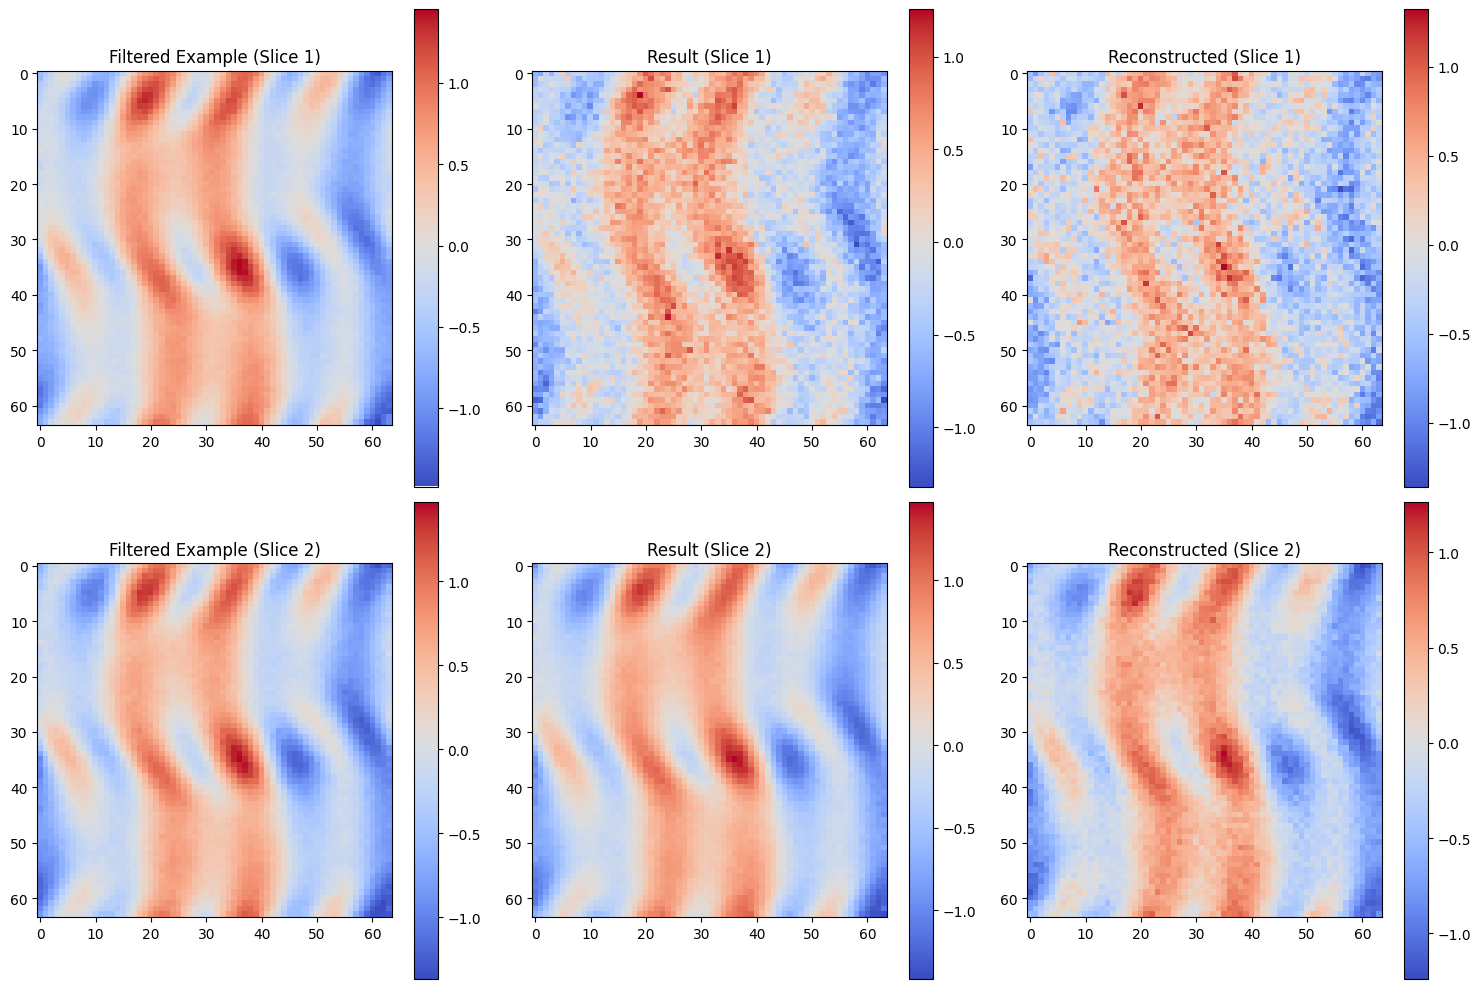

In [32]:
plt.figure(figsize=(15, 10))

# First row: first slice
plt.subplot(2, 3, 1)
plt.imshow(Phi_hat_ens[0,0,12,...], cmap='coolwarm')
plt.colorbar()
plt.title('Filtered Example (Slice 1)')

plt.subplot(2, 3, 2)
plt.imshow(Phi_hat_ens[1,0,12,...], cmap='coolwarm')
plt.colorbar()
plt.title('Result (Slice 1)')

plt.subplot(2, 3, 3)
plt.imshow(Phi_hat_ens[4,0,12,...], cmap='coolwarm')
plt.colorbar()
plt.title('Reconstructed (Slice 1)')

# Second row: second slice
plt.subplot(2, 3, 4)
plt.imshow(Phi_hat_ens[6,0,12,...], cmap='coolwarm')  # Different slice
plt.colorbar()
plt.title('Filtered Example (Slice 2)')

plt.subplot(2, 3, 5)
plt.imshow(Phi_hat_ens[8,0,12,...], cmap='coolwarm')  # Different slice
plt.colorbar()
plt.title('Result (Slice 2)')

plt.subplot(2, 3, 6)
plt.imshow(Phi_hat_ens[10,0,12,...], cmap='coolwarm')  # Different slice
plt.colorbar()
plt.title('Reconstructed (Slice 2)')

plt.tight_layout()
plt.show()


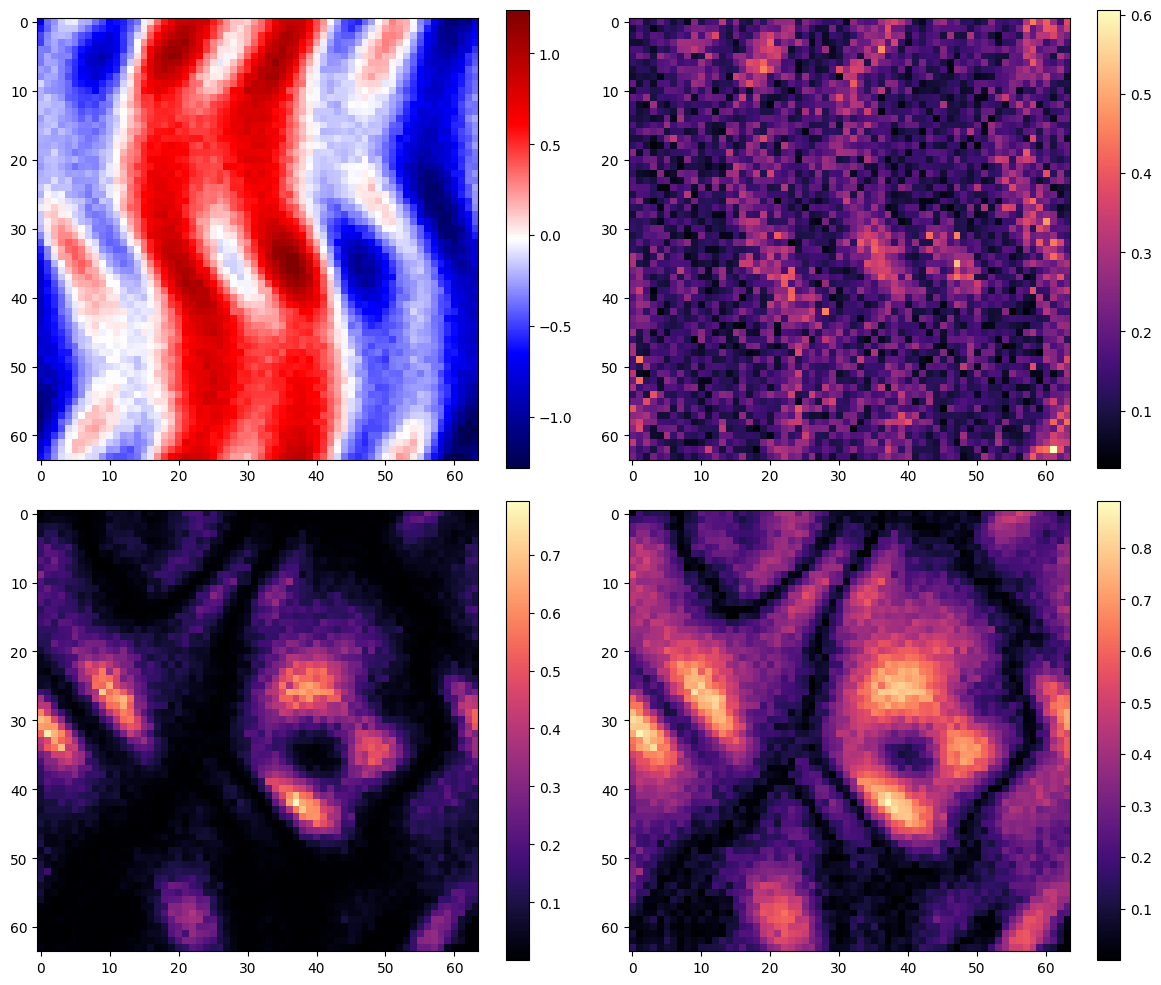

In [33]:
index = 2

plt.figure(figsize=(12, 10))

plt.subplot(2, 2, 1)
plt.imshow(Phi_mean[0, index,...], cmap='seismic')
plt.colorbar()

plt.subplot(2, 2, 2)
plt.imshow(Phi_std[0, index,...], cmap='magma')
plt.colorbar()

plt.subplot(2, 2, 3)
plt.imshow((Phi_mean[0, index,...] - Phi_true[0, index,...])**2, cmap='magma')
plt.colorbar()

plt.subplot(2, 2, 4)
plt.imshow(np.abs(Phi_mean[0, index,...] - Phi_true[0, index,...]), cmap='magma')
plt.colorbar()

plt.tight_layout()
plt.show()

In [37]:
idx = 410
filtered_example = torch.tensor(Phi_inference[:, idx, ...], dtype=torch.float32)

Phi_inference_r_ensemble = np.zeros((15, B, W, H))
for i in tqdm(range(15)) : 
    reconstructed = sample(model, filtered_example).cpu().numpy()
    Phi_inference_r_ensemble[i, ...] = reconstructed

print(Phi_inference_r_ensemble.shape)

100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:27<00:00,  1.81s/it]

(15, 2, 64, 64)


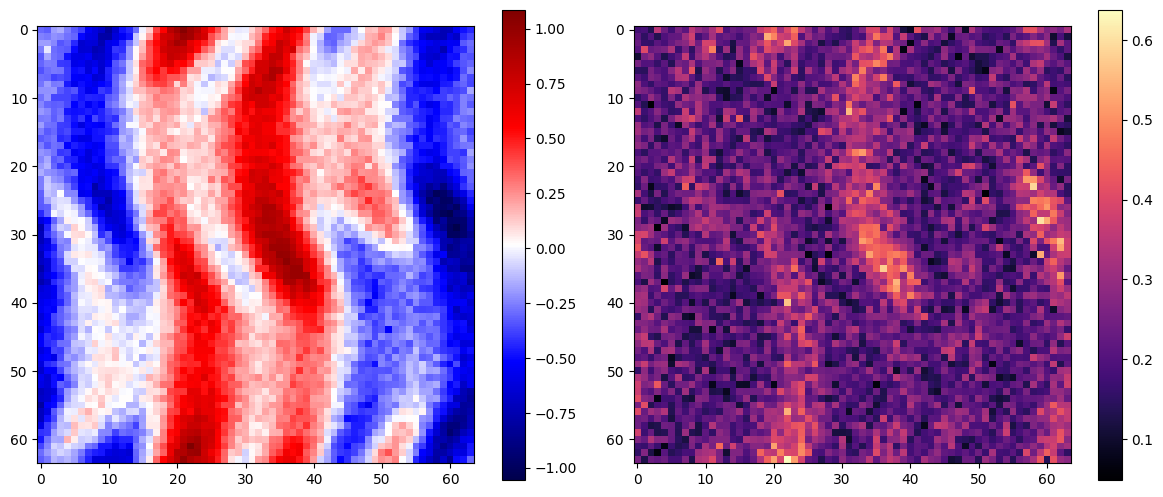

In [38]:
Phi_inference_mean  = np.mean(Phi_inference_r_ensemble, axis = 0)
Phi_inference_std  = np.std(Phi_inference_r_ensemble, axis = 0)

index = 2

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.imshow(Phi_inference_mean[0,...], cmap='seismic')
plt.colorbar()

plt.subplot(1, 2, 2)
plt.imshow(Phi_inference_std[0,...], cmap='magma')
plt.colorbar()

plt.tight_layout()
plt.show()